# Variational AutoEncoders VAE

On fashion dataset from mnist (pictures of clothes)

In [1]:
import tensorflow as tf
import os
import random
import numpy as np

# confirm GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Set a consistent random seed

In [2]:
SEED = 123456
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # new flag present in tf 2.0+
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Fashion data from Mnist

In [3]:
from tensorflow.keras.datasets import fashion_mnist

In [4]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
x_train, y_train, x_test, y_test

(array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],

In [9]:
assert x_train.shape == (60000, 28, 28)
assert x_test.shape  == (10000,28 ,28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [10]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [11]:
import numpy as np
from matplotlib import pyplot as plt

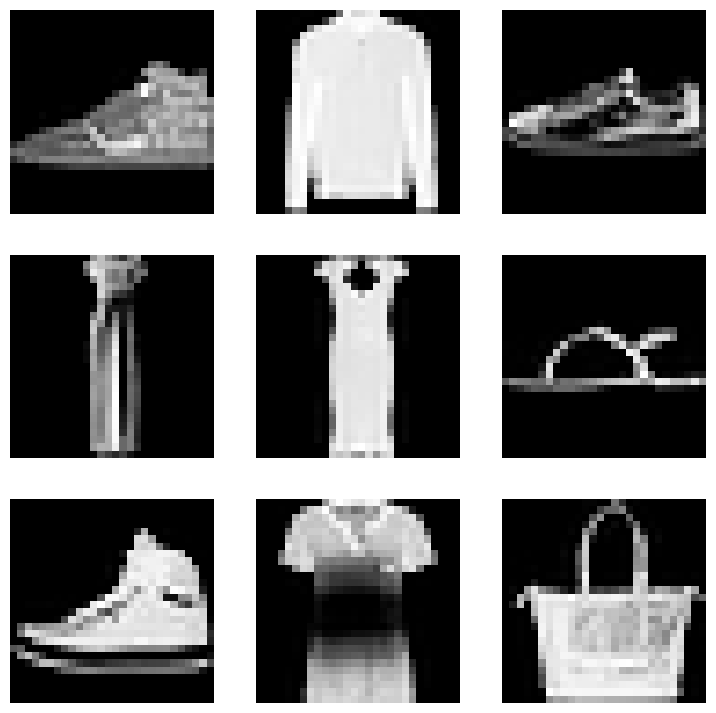

In [13]:
plt.figure(figsize = (9,9))
rndSamples = np.random.choice(60000,9)

for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(x_train[rndSamples[i]], cmap = "Greys_r")
  plt.axis("off")

plt.show()

## Preprocess data

I want to create a system that creates images of clothes/fashion.

Because of that I don't want a training and testing dataset, that is why I concatenate all.

In [14]:
dataset = np.concatenate([x_train,x_test], axis = 0)
# expand_dim converts images from 28x28 to 28x28x1, since convolutional layers expect 3 channels
dataset = np.expand_dims(dataset, -1).astype('float32')/255

## Custom sampling layer

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

In [17]:
#create a sampling layer
class SamplingLayer(layers.Layer):
  """Reparameterization Trick z = mu + sgima*epsilon """

  def call(self, inputs):
    zMean, zLogVar = inputs
    batch = tf.shape(zMean)[0]
    dim = tf.shape(zMean)[1]
    epsilon = tf.keras.backend.random_normal(shape = (batch,dim)) #random term

    return zMean + tf.exp(0.5*zLogVar)*epsilon

  ## Encoder/Decoder

In [18]:
def buildEncoder(latentDim, encoderInputs):

  #Given a batch of images the convolutional block extracts the features
  l1 = keras.models.Sequential([
      layers.Conv2D(128,3, activation='relu', strides = 2, padding = 'same'),
      layers.Conv2D(64,3, activation = 'relu', strides = 2, padding = 'same'),
      layers.Flatten(),
      layers.Dense(256, activation='relu')
  ])
  # pass the inputs through the conolutional block
  x = l1(encoderInputs)

  # a dedicated layer to learn mean in parallel
  zMean = layers.Dense(latentDim, name = 'z_mean')(x)

  # a dedicated layer to learn variance in parallel
  zLogVar = layers.Dense(latentDim, name = 'z_log_var')(x)

  # now the reparametrixation trick to find z as defined by mean and variance
  z = SamplingLayer()([zMean,zLogVar])

  # the actual model which takes the images as input and returns mean, variance and distribution
  # note the zMean and zLogVar are not the final output of the encoder, but
  # they're used in the Kullback-Leibler Divergence Loss
  return keras.Model(encoderInputs, [zMean,zLogVar,z], name = 'encoder')


#trigger the function to actually build the model

encoderInputs = keras.Input(shape = (28,28,1))
encoder = buildEncoder(2, encoderInputs)
encoder.summary()



Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 256)            │        878,144 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            514 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            514 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_layer            │ (None, 2)              │              0 │ z_mean[0][0],          │
│ (SamplingLayer)           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 879,172 (3.35 MB)

 Trainable params: 879,172 (3.35 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
def buildDecoder(latentInputs):
  l1 = keras.models.Sequential([
      layers.Dense(7*7*64, activation='relu', input_shape = (latentInputs.shape[1],)),
      layers.Reshape((7,7,64)),
      layers.Conv2DTranspose(128,3, activation='relu', strides = 2, padding = 'same'),
      layers.Conv2DTranspose(64,3, activation='relu', strides = 2, padding = 'same'),
      layers.Conv2DTranspose(1,3, activation='sigmoid', padding = 'same')
  ])

  return keras.Model(latentInputs, l1(latentInputs), name = 'decoder')

# build the actual model
latentInputs = keras.Input(shape = (2,))
decoder = buildDecoder(latentInputs)
decoder.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 28, 28, 1)           │         157,633 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 157,633 (615.75 KB)

 Trainable params: 157,633 (615.75 KB)

 Non-trainable params: 0 (0.00 B)

## Loss functions

VAE has 2 loss functions!

First the reconstruction loss, which penalizes images that are not similar to the original images.

In [22]:
def reconstructionLoss(data, reconstructed):
  return tf.reduce_mean(
      tf.reduce_sum(
          keras.losses.binary_crossentropy(data, reconstructed),
          axis = (1,2)
      )
  )

Second we have the Kullback-Leibler Divergence loss function (earth mover loss).

In [24]:
def KLDivergenceLoss(zMean,zLogVar):
  return tf.reduce_mean(
      tf.reduce_sum(
          -0.5*( 1+ zLogVar - tf.square(zMean) - tf.exp(zLogVar)),
          axis = 1
      )
  )

Combining these into total loss function.

Weight (alpha) is an important hyperparameter.

In [26]:
def calcTotalLoss(data, reconstructed, zMean, zLogVar):
  loss1 = reconstructionLoss(data, reconstructed)
  loss2 = KLDivergenceLoss(zMean, zLogVar)
  klWeight = 3.0

  return loss1, loss2, loss1 + klWeight*loss2

## Overriding train_step

Since we're using a custom loss function on $\mu$ e $\sigma$, we need to override how the loss is calculated.

We need to compare x_original with x_reconstructed at the same time while calculating KL loss

In [36]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    # register total loss as an observable metric in the model training history
    self.totalLossTracker = keras.metrics.Mean(name="total_loss")
    self.ceLossTracker = keras.metrics.Mean(name="ce_loss")
    self.klLossTracker = keras.metrics.Mean(name="kl_loss")

  # This are all observable metrics
  @property
  def metrics(self):
    return [
        self.totalLossTracker,
        self.ceLossTracker,
        self.klLossTracker
    ]

  # Now calculate loss + calculate gradients + update weights
  def train_step(self, data):
    # Gradient tape is a recording of all gradients for the trainable
    # weights that need to be updated
    with tf.GradientTape() as tape:
        # forward path
        zMean, zLogVar, z = self.encoder(data)
        reconstruction = self.decoder(z)
        ceLoss, klLoss, totalLoss = calcTotalLoss(data, reconstruction, zMean, zLogVar)
    # backward path
    grads = tape.gradient(totalLoss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    # keep track of loss
    self.totalLossTracker.update_state(totalLoss)
    self.ceLossTracker.update_state(ceLoss)
    self.klLossTracker.update_state(klLoss)

    # return the loss for history object
    return {
        "total_loss": self.totalLossTracker.result(),
        "ce_loss": self.ceLossTracker.result(),
        "kl_loss": self.klLossTracker.result()
    }

## Train VAE

In [37]:
vae = VAE(encoder, decoder)
vae.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001))
history = vae.fit(dataset, epochs = 32, batch_size = 128)

Epoch 1/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - ce_loss: 265.7043 - kl_loss: 4.5569 - total_loss: 279.3753
Epoch 2/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - ce_loss: 260.9141 - kl_loss: 4.7237 - total_loss: 275.0853
Epoch 3/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - ce_loss: 259.1920 - kl_loss: 4.7763 - total_loss: 273.5211
Epoch 4/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - ce_loss: 258.0005 - kl_loss: 4.8086 - total_loss: 272.4262
Epoch 5/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - ce_loss: 256.9844 - kl_loss: 4.8640 - total_loss: 271.5763
Epoch 6/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - ce_loss: 256.1378 - kl_loss: 4.8808 - total_loss: 270.7803
Epoch 7/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - ce_loss: 255.6944 - kl_loss: 4.9207 - total_loss: 270.4565
Epoch 8/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - ce_loss: 254.8470 - kl_loss: 4.9425 - total_loss: 269.6744
Epoch 9/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - ce_loss: 254.5933 - kl_loss:

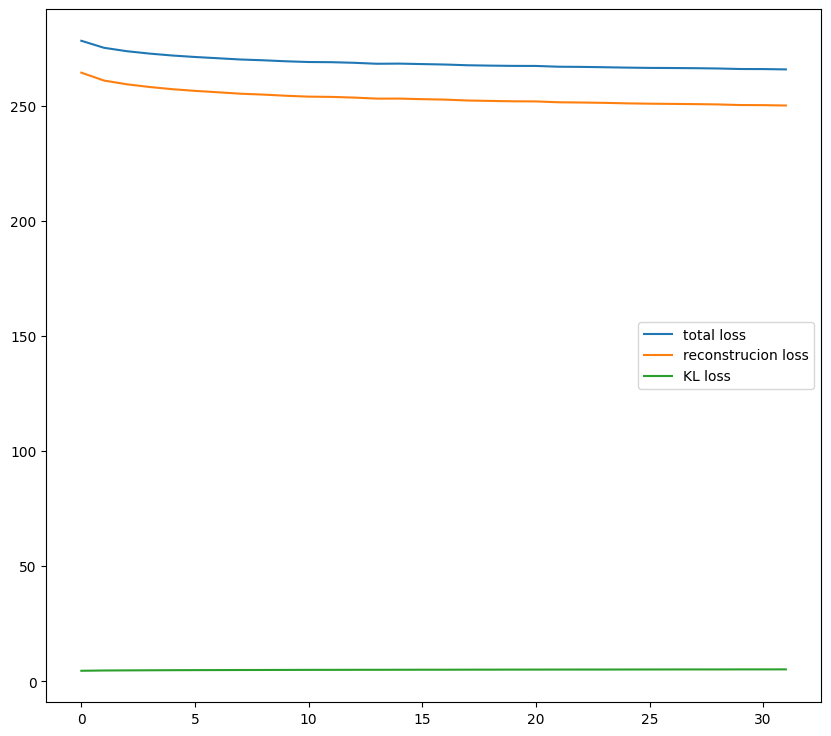

In [40]:
plt.figure(figsize=(10,9))
plt.plot(history.history.get('total_loss'),label = 'total loss')
plt.plot(history.history.get('ce_loss'),label = 'reconstrucion loss')
plt.plot(history.history.get('kl_loss'),label = 'KL loss')
plt.legend()

zoom in the KL loss

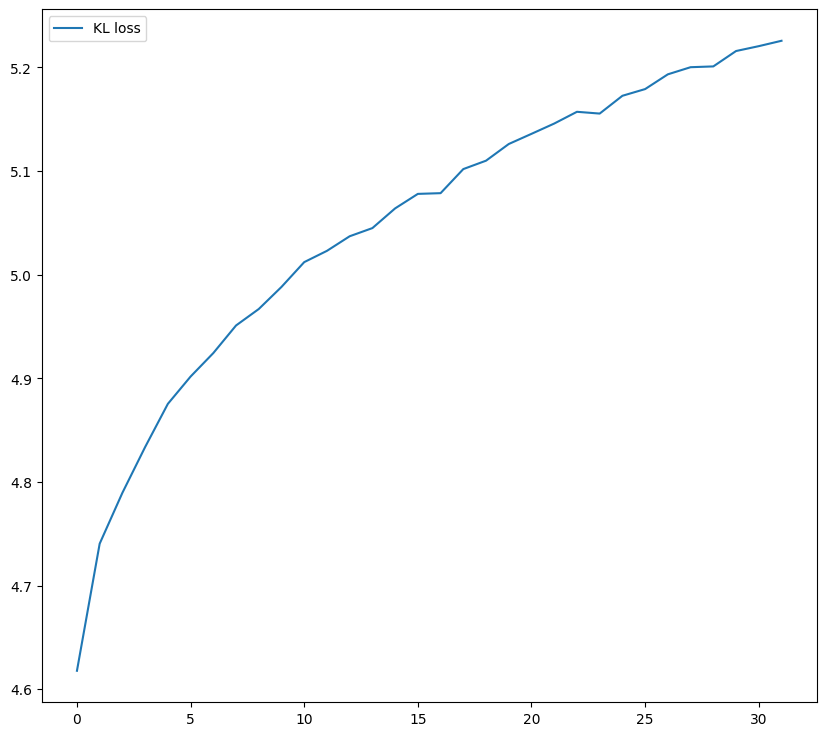

In [41]:
plt.figure(figsize=(10,9))
plt.plot(history.history.get('kl_loss'),label = 'KL loss')
plt.legend()

There are improvements for the KL loss so more epochs would be beneficial (and there are no improvements for the reconstruction loss)

## Explore results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


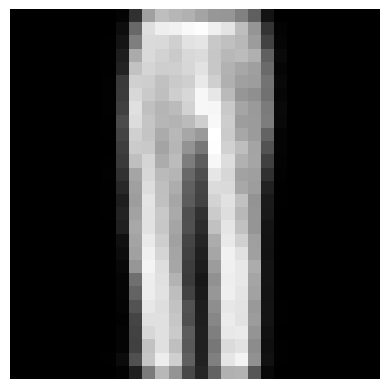

In [43]:
synth = vae.decoder.predict(np.array([[1, 2]]))
plt.axis('off')
plt.imshow(synth.reshape((28,28)), cmap="Greys_r");

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


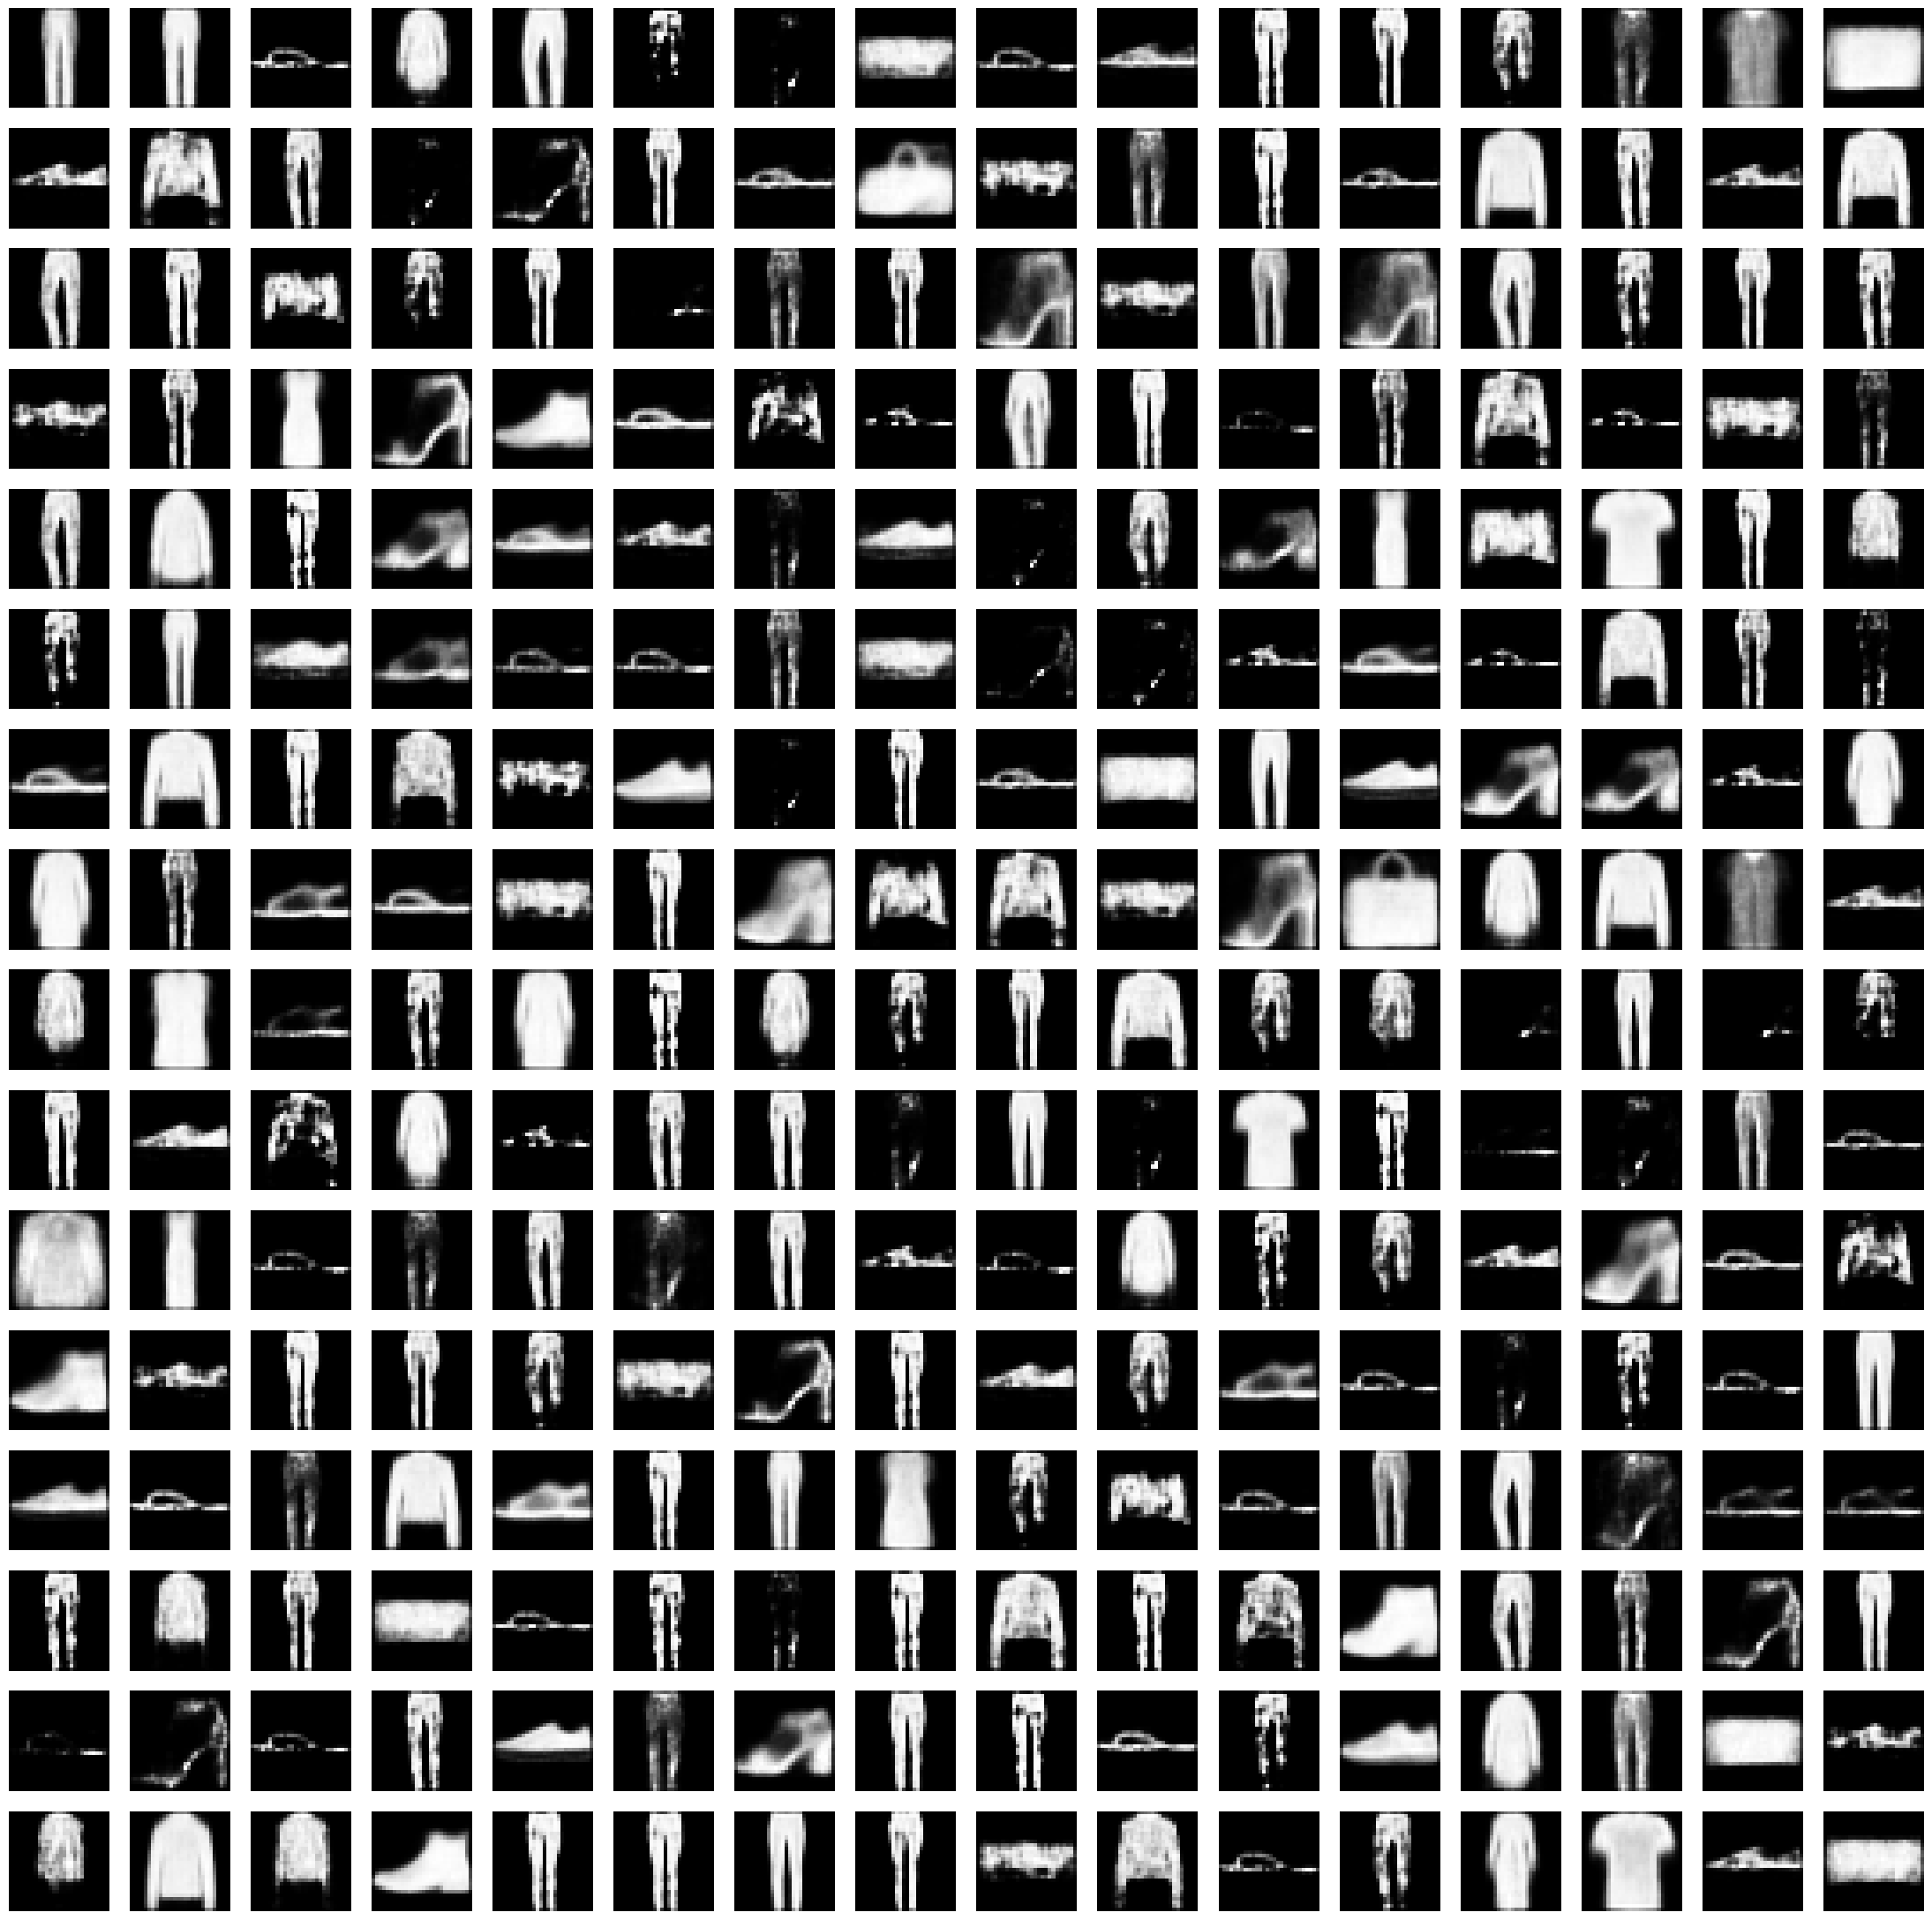

In [44]:
z = np.random.normal(loc = 0, scale = 4, size = (256,2))
synth = vae.decoder.predict(z)

plt.figure(figsize=(28,28))

for i in range(256):
  plt.subplot(16,16,i+1)
  plt.imshow(synth[i].reshape((28,28)), cmap='Greys_r')
  plt.axis('off')

plt.show()

## Draw specific type of clothe

In [48]:
idx = 1111
batch = np.expand_dims(x_train[idx], axis= 0)
batchOfImages = np.expand_dims(batch, axis=-1).astype('float32')/255
print(batchOfImages.shape)

#obtain z(mu,sgima) for the given image

_,_,z = vae.encoder.predict(batchOfImages)

# reconstruct a similar image
synth = vae.decoder.predict([z])

z

(1, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


array([[-1.1978688 , -0.00749755]], dtype=float32)

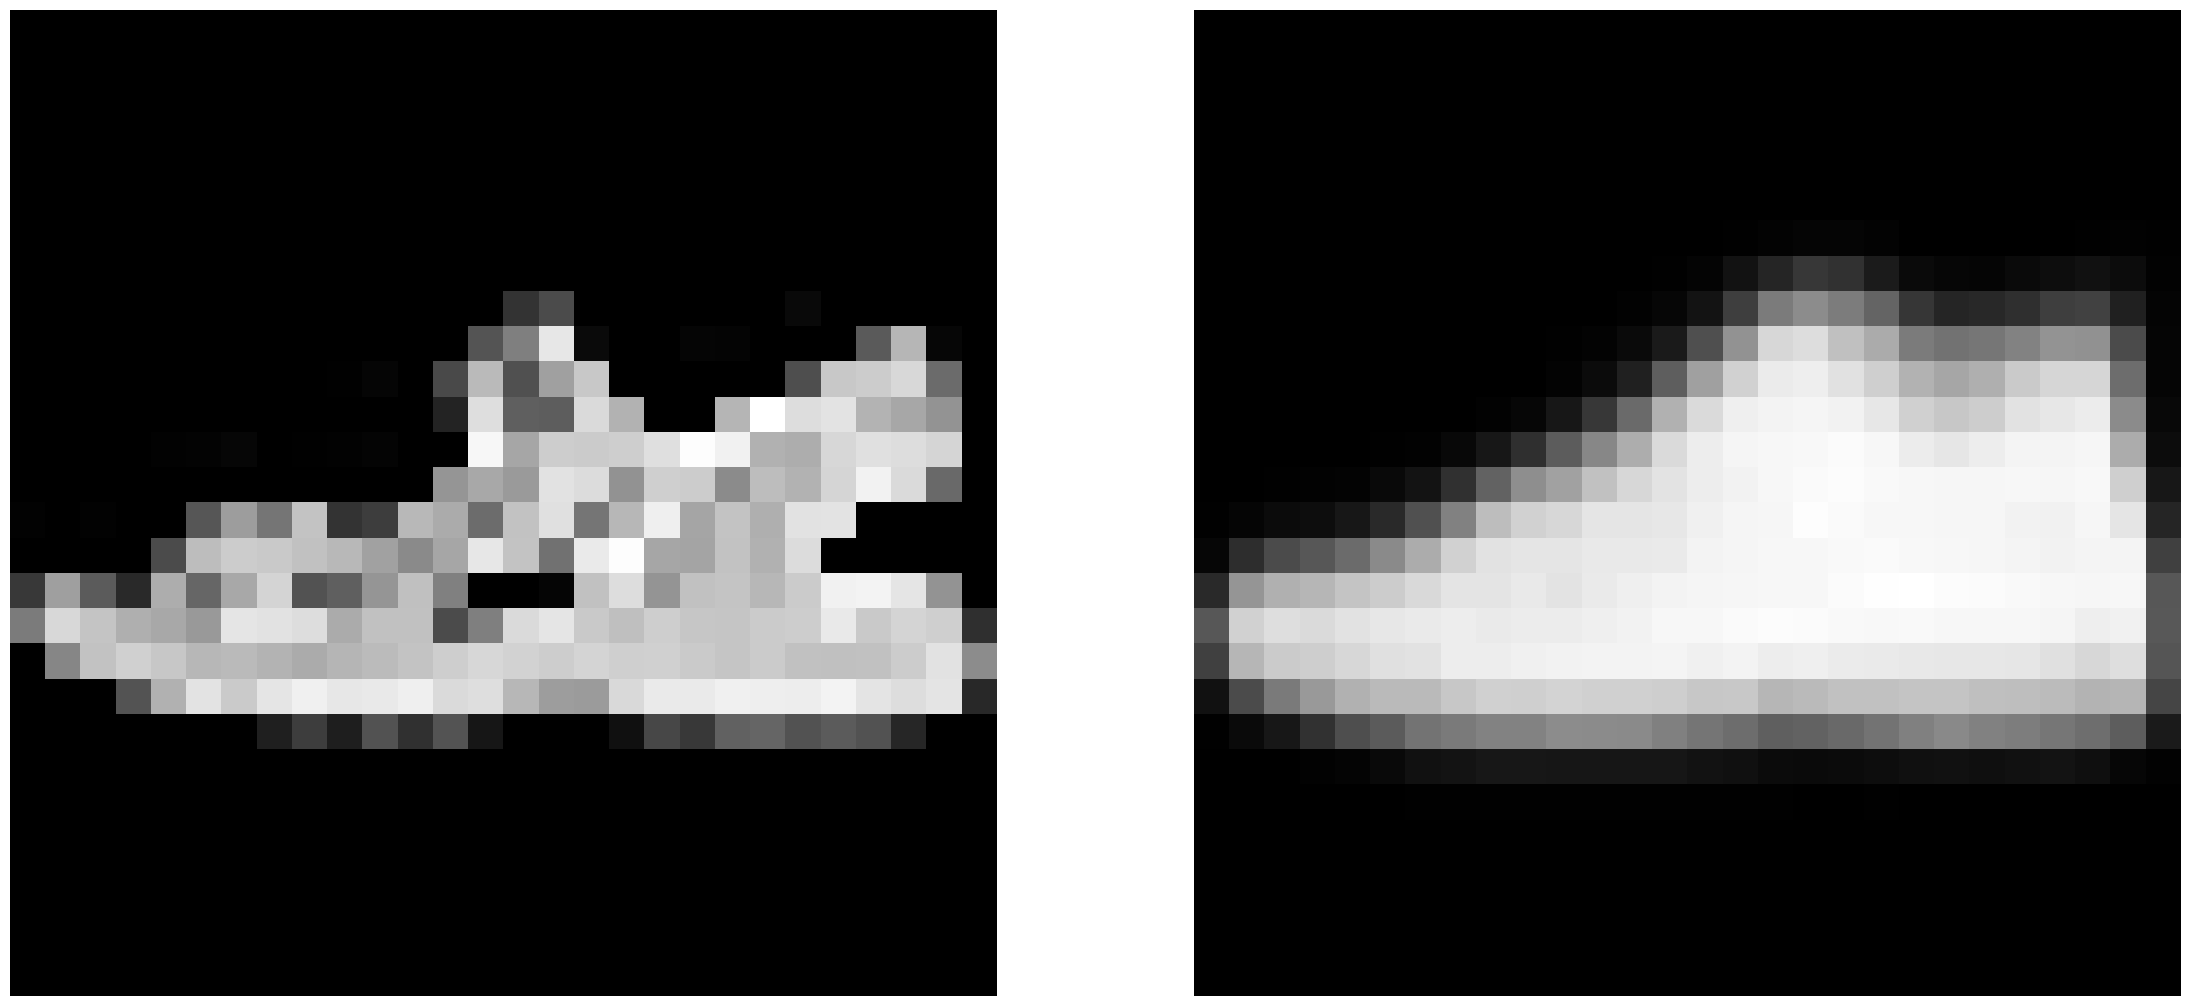

In [49]:
plt.figure(figsize=(28,28))

#original image
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(x_train[idx], cmap = 'Greys_r')

#reconstructed image
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(synth[0].reshape((28,28)), cmap = 'Greys_r')

VAE can be used in unsupervised learning of large text or unlabeled images corpus to cluster the samples into categories.

Look how the prob. distribution with the actual label of the image

2188/2188 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


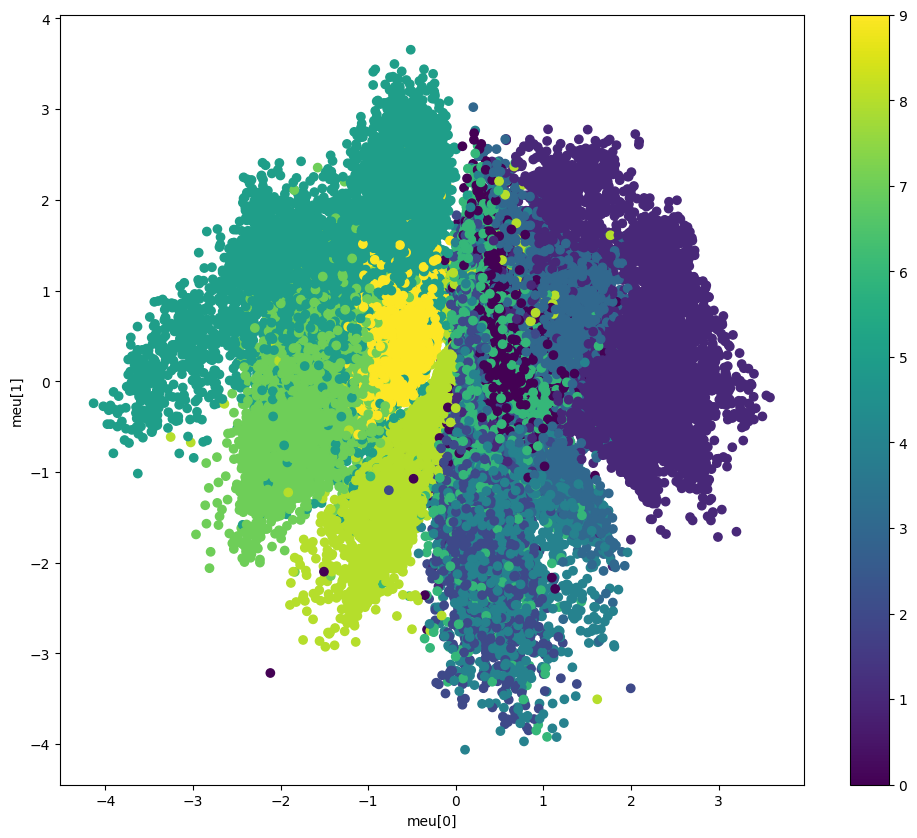

In [50]:
labels = np.concatenate([y_train, y_test], axis=0)
meu, _, _ = vae.encoder.predict(dataset)
plt.figure(figsize=(12, 10))
plt.scatter(meu[:, 0], meu[:, 1], c=labels)
plt.colorbar()
plt.xlabel("meu[0]")
plt.ylabel("meu[1]")
plt.show();

W can see that each type of clothes has different prob. distributions